In [7]:
import import_ipynb
from Execution_Final import Scheduler
from Read_Data import Read_data
import Neural_Network
from Neural_Network import Trainer
from Neural_Network import DataModule
from Optimiser import optimiser
from Optimiser_ro import optimiser_ro
import numpy as np
import Plots
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde
from tqdm import tqdm
from sklearn import preprocessing
import math
from scipy.stats import norm

In [8]:
MUL_DEMAND = 1500
MUL_PRICE = 1000/340.2
MUL_YIELD = 2000
TRUE_WEEKS = 24

hyper = {'window':          {'Demand': 17,      'Price': 12,     'Yield': 15    },
         'hs':              {'Demand': 24,      'Price': 10,     'Yield': 16    },
         'num_layers':      {'Demand': 1,       'Price': 2,      'Yield': 2     },
         'lr':              {'Demand': 0.00005, 'Price': 0.0001, 'Yield': 0.0001},
         'patience':        {'Demand': 3000,    'Price': 2000,   'Yield': 10000 },
         'warm':            {'Demand': 500,     'Price': 200,    'Yield': 200   },
         'portion_val':     {'Demand': 0.1,     'Price': 0.1,    'Yield': 0.1   },
         'portion_test':    {'Demand': 0.1,     'Price': 0.1,    'Yield': 0.1   },
         'batch_size':      {'Demand': 128,     'Price': 128,    'Yield': 128   }
        }

parameters = {'Th': 1,
              'Tt': 2,
              'Zt': 0.1,
              'Zh': 0.1,
              'Ztruck': 100, 
              'theta_i': 0.9,
              'theta_t': 0.9,
              'theta_r': 0.6,
              'weightPrice_more': 0.0001,
              'weightPrice_less': -0.0001,
              'weightDiscount':0.5,
              'weightShortage': 2,
              'capacity_inv': 5000,
              'capacity_truck': 500,
              'F_proportion': 0.7
              }

GAMMA = 0.1

## Yield Distribution Plot

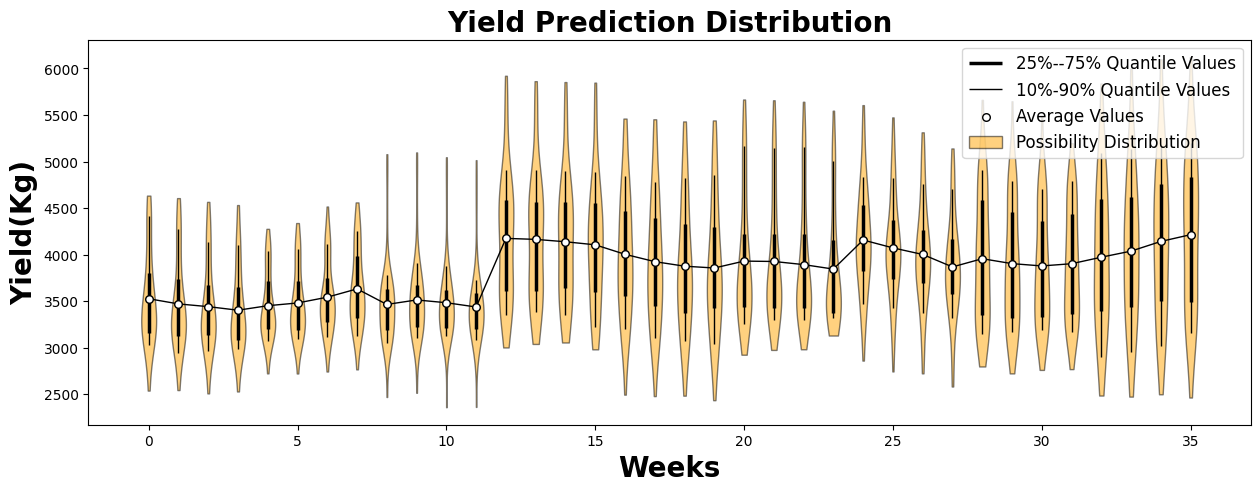

In [9]:
yieldEn_predictions = np.load('Predictions/yield_prediction2.npy')
Plots.plot_confidence('Yield', yieldEn_predictions, figsize=(15, 5))

## Generation of Prediction Scenarios and Dataclass

In [10]:
demand = Read_data('Data/Strawberry Demand.csv', 'Demand', true_weeks=TRUE_WEEKS, mul=MUL_DEMAND, window=hyper['window']['Demand'])
price = Read_data('Data/Strawberry Price.csv', 'Price', true_weeks=TRUE_WEEKS, mul=MUL_PRICE, window=hyper['window']['Price'])
syield = Read_data('Data/Yield.csv', 'Yield', true_weeks=TRUE_WEEKS, mul=MUL_YIELD, window=hyper['window']['Yield'])


def scenarios_generation() -> tuple:
    '''
    Read all the predictions and group them according to the min, avr and max values.
    return: scenarios, source (specifying which kind of prediction it is), predictions.
    '''
    yieldEn_predictions = np.load('Predictions/yield_prediction.npy')
    priceEn_predictions = np.load('Predictions/price_prediction.npy')
    demandEn_predictions = np.load('Predictions/demand_prediction.npy')

    source = {}
    source['yieldEn_predictions'] = yieldEn_predictions
    source['priceEn_predictions'] = priceEn_predictions
    source['demandEn_predictions'] = demandEn_predictions

    predictions = {}
    scenarios = ['Min', 'Average', 'Max', 'True']
    
    for distribution in ['yieldEn_predictions', 'priceEn_predictions', 'demandEn_predictions']:
        predictions[distribution] = {}
        predictions[distribution]['Min'] = np.min(source[distribution], axis=0)
        predictions[distribution]['Max'] = np.max(source[distribution], axis=0)
        predictions[distribution]['Average'] = np.mean(source[distribution], axis=0)
    
    return scenarios, source, predictions

## Comparison among the Theorical Best Profits

In [11]:
def compare_theory() -> np:
    '''
    Optimise all the weeks according to the previous prediction.
    return: The theoretical maximum profits under different scenarios.
    '''
    scenarios, _, predictions = scenarios_generation()
    
    profit = np.zeros((len(scenarios), TRUE_WEEKS//4))
    profit_baseline = np.zeros((TRUE_WEEKS//4))
    optimiser = Scheduler(demand, price, syield)

    for row, scenario in enumerate(scenarios):
        print('---------------------- Scenario: ' + scenario + ' Yield ----------------------')
        for i in range(TRUE_WEEKS//4):
            print('=========== Month ' + str(i) + ' ================')
            
            if scenario == 'True':
                if -TRUE_WEEKS + (i+1) * 4 != 0:
                    yield_pre = syield.true_data[-TRUE_WEEKS + i * 4: -TRUE_WEEKS + (i+1) * 4]
                else:
                    yield_pre = syield.true_data[-TRUE_WEEKS + i * 4:]
            else:
                yield_pre = predictions['yieldEn_predictions'][scenario][i*4:(i+1)*4]  
                
            price_pre = predictions['priceEn_predictions']['Average'][i*4:(i+1)*4] 
            demand_pre = predictions['demandEn_predictions']['Average'][i*4:(i+1)*4]
            optimiser.optimise(parameters, yield_pre, demand_pre, price_pre)
            profit[row, i] = optimiser.arrangement_record[optimiser.counter]['Profit']

            # Baseline strategy optimiser
            if scenario == 'True':
                optimiser.optimise(parameters, yield_pre, demand_pre, price_pre, manual_demand=demand_pre, manual_price=price_pre)
                profit_baseline[i] = optimiser.arrangement_record[optimiser.counter]['Profit']

    Plots.plot_lines(profit, title='Theoretical Maximum Profits under Various Yield Values', 
                     xlabel='Months', ylabel='Profit($)', label=scenarios, show_label=1, index1=0, index2=2, labelsize=15, xticks=np.arange(0, TRUE_WEEKS//4))
    
    # Baseline VS Optimised
    Plots.plot_lines(np.concatenate((profit[-1], profit_baseline), axis=0).reshape(2, -1), title='Profit of Baseline Strategy VS Optimised Strategy', 
                     xlabel='Months', ylabel='Profit($)', label=['Optimised Strategy', 'Baseline Strategy'], show_label=1, labelsize=15, xticks=np.arange(0, TRUE_WEEKS//4))
    Plots.plot_bars(np.concatenate((profit[-1], profit_baseline), axis=0).reshape(2, -1), title='Profit of Baseline Strategy VS Optimised Strategy', 
                     xlabel='Months', ylabel='Profit($)', labels=['Optimised Strategy', 'Baseline Strategy'], ylim=[profit_baseline.min() * 0.9, profit[-1].max() * 1.1])
    # Calculation the Improvements
    improvement = ((profit[-1] - profit_baseline) / profit_baseline * 100).reshape(1, -1)
    Plots.plot_lines(improvement, title='The Improvement of the Profit', 
                     xlabel='Months', ylabel='Improvement(%)', label=['Improvement'], show_label=1, labelsize=15, xticks=np.arange(0, TRUE_WEEKS//4))
    
    return profit

---------------------- Scenario: Min Yield ----------------------
=========== Month 0 ================
=========== Month 1 ================
=========== Month 2 ================
=========== Month 3 ================
=========== Month 4 ================
=========== Month 5 ================
---------------------- Scenario: Average Yield ----------------------
=========== Month 0 ================
=========== Month 1 ================
=========== Month 2 ================
=========== Month 3 ================
=========== Month 4 ================
=========== Month 5 ================
---------------------- Scenario: Max Yield ----------------------
=========== Month 0 ================
=========== Month 1 ================
=========== Month 2 ================
=========== Month 3 ================
=========== Month 4 ================
=========== Month 5 ================
---------------------- Scenario: True Yield ----------------------
=========== Month 0 ================
=========== Month 1 ========

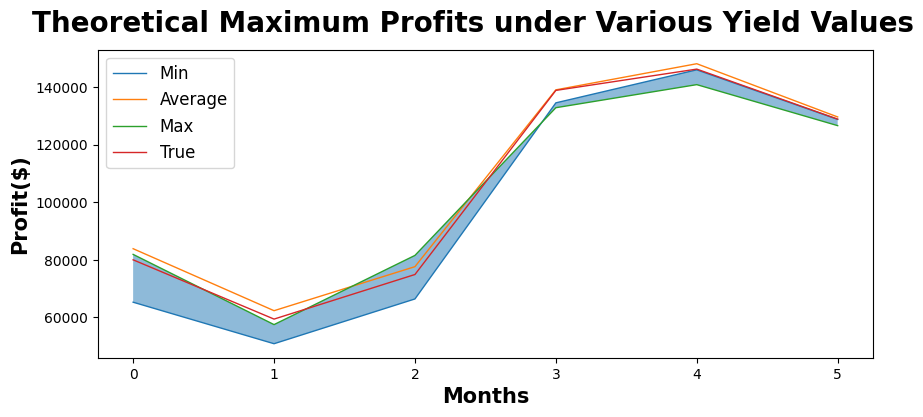

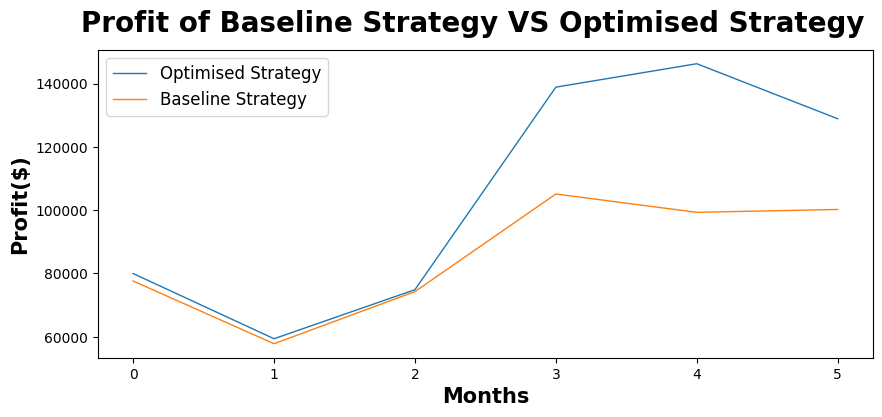

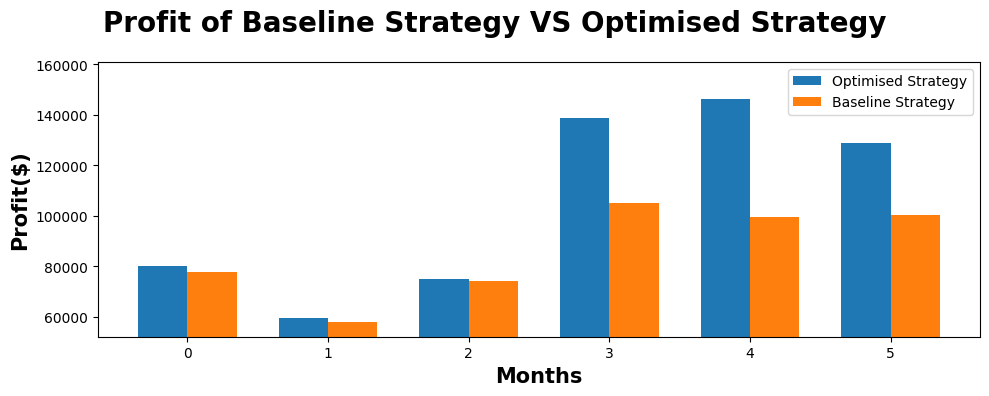

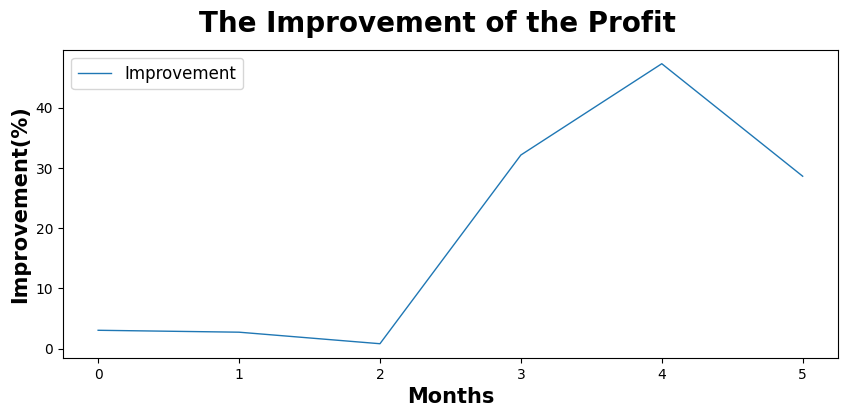

In [12]:
_ = compare_theory()

## Compare Profits by Executing the Average Contract under Various Scenarios

In [13]:
def exe_contract() -> np:
    '''
    Execute the contract, which is obtained when assuming yield=average prediction, under various scenarios.

    return: Numpy array containing all the profits.
    '''
    _, _, predictions = scenarios_generation()
    scenarios = ['Min', 'Average', 'Max'] # 'True' is deleted.

    batches = math.ceil(syield.predict_length/parameters['Th'])
    days = syield.predict_length * 7
    profit = np.zeros((len(scenarios)+1, TRUE_WEEKS//4))
    shortage = np.zeros((2, TRUE_WEEKS//4))

    optimiser = Scheduler(demand, price, syield)
    executor = Scheduler(demand, price, syield)

    for i in range(TRUE_WEEKS//4):
        # Obtain the standard contract.
        yield_pre = predictions['yieldEn_predictions']['Average'][i*4:(i+1)*4]  
        yield_min = predictions['yieldEn_predictions']['Min'][i*4:(i+1)*4]  
        price_pre = predictions['priceEn_predictions']['Average'][i*4:(i+1)*4] 
        demand_pre = predictions['demandEn_predictions']['Average'][i*4:(i+1)*4]
        optimiser.optimise(parameters, yield_pre, demand_pre, price_pre)
        contract_demand = optimiser.arrangement_record[optimiser.counter]['contract_demand']
        contract_price = optimiser.arrangement_record[optimiser.counter]['contract_price']

        # Obtain the robust contract.
        H_variation = np.zeros((batches, days))
        H_Tao = np.zeros((batches, days))
        for j in range(batches):
            H_variation[j, j*7] = yield_pre[j] - yield_min[j]
            H_Tao[j, 7*j: ] = GAMMA
        optimiser.robust_optimise(parameters, yield_pre, demand_pre, price_pre, H_Tao, H_variation)
        contract_demandRO = optimiser.arrangementRO_record[optimiser.counter]['contract_demand']
        contract_priceRO = optimiser.arrangementRO_record[optimiser.counter]['contract_price']
        
        # Execute the contracts and see the profits.
        for row, scenario in enumerate(scenarios):
            executor.optimise(parameters, predictions['yieldEn_predictions'][scenario], demand_pre, price_pre, manual_demand=contract_demand, manual_price=contract_price)
            profit[row, i] = executor.arrangement_record[executor.counter]['Profit']
            if scenario == 'Min':
                shortage[0, i] = executor.arrangement_record[executor.counter]['Shortage_cost']
                executor.optimise(parameters, predictions['yieldEn_predictions'][scenario], demand_pre, price_pre, manual_demand=contract_demandRO, manual_price=contract_priceRO)
                profit[-1, i] = executor.arrangement_record[executor.counter]['Profit']
                shortage[1, i] = executor.arrangement_record[executor.counter]['Shortage_cost']

    # Profits Comparison.
    Plots.plot_lines(profit, title='Actual Profits of the Producer under Various Yield Scenarios', 
                        xlabel='Months', ylabel='Profit($)', label=scenarios+['Robust Optimization'], show_label=1, index1=0, index2=2, labelsize=15, xticks=np.arange(0, TRUE_WEEKS//4))   
    # Min yield VS Robust optimisation.
    Plots.plot_lines(np.array([profit[0, :], profit[-1, :]]).reshape(2, -1), title='Profits of Standard Contract and Robust Contract, Yield=Min', 
                        xlabel='Months', ylabel='Profit($)', label=['Standard Optimization', 'Robust Optimization'], show_label=1, labelsize=15, xticks=np.arange(0, TRUE_WEEKS//4))
    # Shortage comparison.
    Plots.plot_lines(shortage, title='Shortage of Standard Contract and Robust Contract, Yield=Min', 
                        xlabel='Months', ylabel='Shortage($)', label=['Standard Optimization', 'Robust Optimization'], show_label=1, labelsize=15, xticks=np.arange(0, TRUE_WEEKS//4))
    # Improvement.
    Plots.plot_lines(((profit[-1] - profit[0])/profit[0] * 100).reshape(1, -1), title='Improvement in Percent', 
                        xlabel='Months', ylabel='Improvement(%)', label=['Improvement'], show_label=1, labelsize=15, xticks=np.arange(0, TRUE_WEEKS//4))
    
    return profit

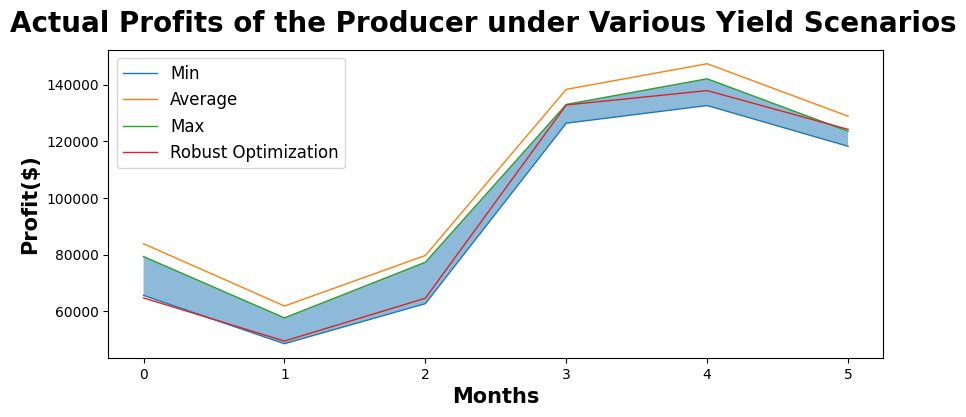

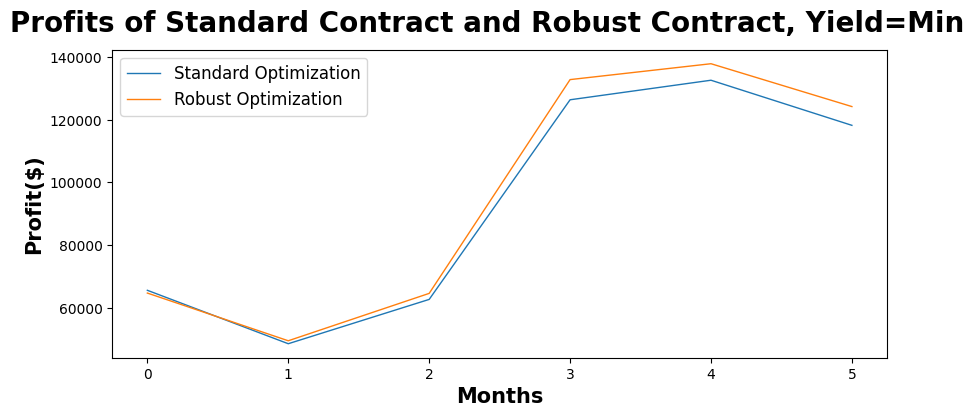

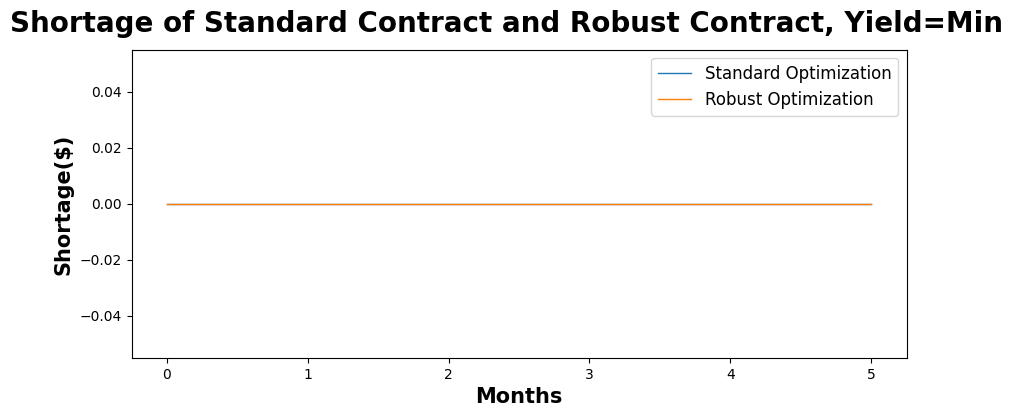

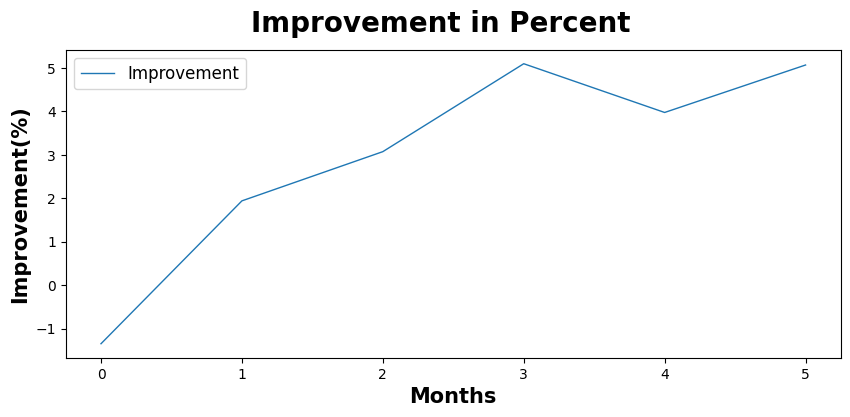

array([[ 65593.06376127,  48540.29806233,  62682.16022952,
        126398.19014593, 132637.25758453, 118242.14113595],
       [ 83844.28626432,  61855.29759024,  79696.83580037,
        138348.10663078, 147399.96042252, 128882.12228652],
       [ 79311.1339452 ,  57665.45356667,  77307.10356995,
        133029.59280266, 142081.4465944 , 123563.60845839],
       [ 64709.03187664,  49481.45427186,  64607.13501872,
        132836.79404827, 137906.10513548, 124230.36830431]])

In [14]:
exe_contract()

## Study the Effect of GAMMA on the Profit

In [15]:
def Gamma_study(i: int, grid: np):
    profit = []
    profit_exp = []
    batches = math.ceil(syield.predict_length/parameters['Th'])
    days = syield.predict_length * 7

    _, _, predictions = scenarios_generation()
    yield_pre = predictions['yieldEn_predictions']['Average Yield'][i*4:(i+1)*4]  
    yield_min = predictions['yieldEn_predictions']['Min Yield'][i*4:(i+1)*4] 
    price_pre = predictions['priceEn_predictions']['Average Yield'][i*4:(i+1)*4] 
    demand_pre = predictions['demandEn_predictions']['Average Yield'][i*4:(i+1)*4]
    H_variation = np.zeros((batches, days))
    H_Tao = np.zeros((batches, days))
    
    optimiser = Scheduler(demand, price, syield)
    executor = Scheduler(demand, price, syield)

    for GAMMA in grid:
        print(GAMMA)

        for j in range(batches):
            H_variation[j, j*7] = yield_pre[j] - yield_min[j]
            H_Tao[j, 7*j: ] = GAMMA

        optimiser.robust_optimise(parameters, yield_pre, demand_pre, price_pre, H_Tao, H_variation)
        contract_demandRO = optimiser.arrangementRO_record[optimiser.counter]['contract_demand']
        contract_priceRO = optimiser.arrangementRO_record[optimiser.counter]['contract_price']
        executor.optimise(parameters, yield_min, demand_pre, price_pre, manual_demand=contract_demandRO, manual_price=contract_priceRO)
        profit.append(executor.arrangement_record[executor.counter]['Profit'])
        probability = norm.cdf(yield_pre - (1 - GAMMA) * (yield_pre - yield_min), yield_pre - yield_min, yield_pre).sum()/4
        profit_exp.append(executor.arrangement_record[executor.counter]['Profit'] * probability)
    Plots.plot_lines(np.array(profit).reshape(1, -1), x=grid, xlabel='Γ', ylabel='Profit($)', title='The Effection of Γ on Profit', label=['Profit'], show_label=1)
    Plots.plot_lines(np.array(profit_exp).reshape(1, -1), x=grid, xlabel='Γ', ylabel='Profit($)', title='Profit Expectation Changing with Γ', label=['Profit Expectation'], show_label=1)
